In [1]:
import os
import glob
import pandas as pd
from tqdm.auto import tqdm
import time
import numpy as np
import numpy.ma as ma

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


# Read in the data to on dictionary of each Modal

In [2]:


sensor_list = ['act', 'acw', 'dc', 'pm']
# Test out the read in helper function
def get_subject_action(sensor, full_path):
    index = full_path.find(sensor)
    index += len(sensor)
    subject = int(full_path[index+1:index+3])
    action = int(full_path[index+4:index+6])
    if action == 4:
        if full_path.find(f"{sensor}_1") > 0:
            action = '4-1'
        else:
            action = '4-2'
        
    return (subject, str(action))

for sensor in sensor_list:
    for sensor_dir in glob.iglob('.\\data\\' + sensor ):
        print(f"On {sensor}")
        for subject_id, subject_dir in enumerate(glob.iglob(f"{sensor_dir}\\*")):
            for action_id, file in enumerate(os.listdir(subject_dir)):
                full_path = f"{subject_dir}\\{file}"
                #print(full_path, get_subject_action(sensor, full_path))
                
test_str = '.\\data\\act\\01\\01_act_1.csv'
get_subject_action('act', test_str)

On act
On acw
On dc
On pm


(1, '1')

In [3]:
%%time
total_data = {
    'act': None,
    'acw': None,
    'dc': None,
    'pm': None,
}


headers = {
    'act': ['times', 'X', 'Y', 'Z'],
    'acw': ['times', 'X', 'Y', 'Z'],
    'dc': ['times'],
    'pm': ['times']
}
for i in range(1,513):
    headers['pm'].append(f"sensor_{i}")
for i in range(1,193):
    headers['dc'].append(f"sensor_{i}")

actions = ['1', '2', '3', '4-1', '4-2', '5', '6', '7']

sensor_list = ['act', 'acw', 'dc', 'pm']
#sensor_list = ['acw']

# there are 956 files in our dataset
i = 0

pbar = tqdm(desc="load data", total=956)
for sensor in sensor_list:
    for sensor_dir in glob.iglob('.\\data\\' + sensor ):
        #print(f"On {sensor}")
        for subject_id, subject_dir in enumerate(glob.iglob(f"{sensor_dir}\\*")):
            for action_id, file in enumerate(os.listdir(subject_dir)):
                full_path = f"{subject_dir}\\{file}"
                df_tmp = pd.read_csv(full_path, names=headers[sensor])
                i+=1
                pbar.update(1)
                subject, action = get_subject_action(sensor, full_path)
                # add one to make it match the given format
                df_tmp['subject'] = subject
                df_tmp['action'] = action
                if total_data[sensor] is None:
                    total_data[sensor] = df_tmp
                else:
                    total_data[sensor] = pd.concat([total_data[sensor], df_tmp])

load data:   0%|          | 0/956 [00:00<?, ?it/s]

Wall time: 1min 2s


## Show what is in each

In [14]:
for key in total_data.keys():
    if total_data[key] is not None:
        print(key)
        print(total_data[key]['action'].unique())
        print(total_data[key]['subject'].unique())
        for header in headers[key]:
            if(total_data[key][header].isnull().values.any()):
                print(f"{header} has Null data")
        print(total_data[key].info())
        print('-------------------------------------------------------------------------')

act
['1' '2' '3' '4-1' '4-2' '5' '6' '7']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400856 entries, 0 to 6418
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   times    1400856 non-null  object 
 1   X        1400856 non-null  float64
 2   Y        1400856 non-null  float64
 3   Z        1400856 non-null  float64
 4   subject  1400856 non-null  int64  
 5   action   1400856 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 74.8+ MB
None
-------------------------------------------------------------------------
acw
['1' '2' '3' '4-1' '4-2' '5' '6' '7']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313695 entries, 0 to 6013
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  -----

In [15]:
df_acw = total_data['acw']
subject = 1
action = '1'
df_acw[(df_acw.subject == subject) & (df_acw.action == action)]

,times,X,Y,Z,subject,action
0,2018-11-08 11:34:51.474000,0.125000,-0.046875,0.90625,1,1
1,2018-11-08 11:34:51.485000,0.109375,-0.062500,0.90625,1,1
2,2018-11-08 11:34:51.495000,0.109375,-0.062500,0.90625,1,1
3,2018-11-08 11:34:51.505000,0.125000,-0.062500,0.90625,1,1
4,2018-11-08 11:34:51.516000,0.125000,-0.062500,0.90625,1,1
...,...,...,...,...,...,...
6269,2018-11-08 11:35:56.373000,0.093750,-0.265625,0.87500,1,1
6270,2018-11-08 11:35:56.383000,0.093750,-0.281250,0.87500,1,1
6271,2018-11-08 11:35:56.394000,0.093750,-0.265625,0.87500,1,1
6272,2018-11-08 11:35:56.404000,0.093750,-0.265625,0.87500,1,1


In [16]:
total_data['pm'].head()

,times,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_505,sensor_506,sensor_507,sensor_508,sensor_509,sensor_510,sensor_511,sensor_512,subject,action
0,2018-11-08 11:34:51.468000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,68.0,77.0,55.0,193.0,387.0,331.0,125.0,6.0,1,1
1,2018-11-08 11:34:51.535000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,58.0,78.0,53.0,192.0,388.0,330.0,123.0,6.0,1,1
2,2018-11-08 11:34:51.602000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,64.0,78.0,53.0,195.0,390.0,330.0,119.0,7.0,1,1
3,2018-11-08 11:34:51.669000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,66.0,79.0,55.0,196.0,391.0,324.0,106.0,5.0,1,1
4,2018-11-08 11:34:51.737000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,64.0,79.0,55.0,194.0,391.0,321.0,114.0,6.0,1,1


In [17]:
# show reshape is doing what we think
x = np.array([[1,2,3],
          [4,5,6],
          [7,8,9],
          [10,11,12],
          [13,14,15],
          [16,17,18]])
y = np.array(range(0,24))
y = np.reshape(y, (6,4))

z = np.array(range(0,30))
z = np.reshape(z, (6, 5))


np.hstack((x,y,z))

array([[ 1,  2,  3,  0,  1,  2,  3,  0,  1,  2,  3,  4],
       [ 4,  5,  6,  4,  5,  6,  7,  5,  6,  7,  8,  9],
       [ 7,  8,  9,  8,  9, 10, 11, 10, 11, 12, 13, 14],
       [10, 11, 12, 12, 13, 14, 15, 15, 16, 17, 18, 19],
       [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29]])

In [18]:
%%time
# take the total dfs and make batches for each action each subject completed
# samples100 is how many samples should be in the 100HZ (the two accleromter data)
# samples15 is how many samples from the images should be take
subjects = range(1,31)
dc_X_cols = [f"sensor_{i}" for i in range(1,193)]
pm_X_cols = [f"sensor_{i}" for i in range(1,513)]
acw_X_cols = ["X", "Y", "Z"]

def batch_data(total_dfs, seconds=5):
    samples100 = 100*seconds
    samples15 = 15*seconds
    df_acw = total_dfs['acw']
    df_act = total_dfs['act']
    df_dc = total_dfs['dc']
    df_pm = total_dfs['pm']
    
    all_cols = []
    for i in range(0, samples100):
        all_cols += [f"acw_{val}_{i}" for val in acw_X_cols]
    for i in range(0, samples15):
        all_cols += [f"dc_{val}_{i}" for val in dc_X_cols]
    for i in range(0, samples15):
        all_cols += [f"pm_{val}_{i}" for val in pm_X_cols]
    for i in range(0, samples100):
        all_cols += [f"act_{val}_{i}" for val in acw_X_cols]
    
    
    df_all = pd.DataFrame(columns=all_cols+['action'])
    
    actions = df_acw['action'].unique()
    pbar = tqdm(desc="batch data", total=len(subjects)*len(actions))
    for subject in subjects:
        actions = df_acw['action'].unique()
        for action in actions:
            X_acw = df_acw[(df_acw.subject == subject) & (df_acw.action == action)][acw_X_cols].to_numpy()
            X_acw = X_acw[range(0, (X_acw.shape[0]//samples100)*samples100)] # cut off records that don't fit in the window
            X_acw = np.reshape(X_acw, (X_acw.shape[0]//samples100, samples100*len(acw_X_cols)))
            
            X_dc = df_dc[(df_dc.subject == subject) & (df_dc.action == action)][dc_X_cols].to_numpy()
            X_dc = X_dc[range(0, (X_dc.shape[0]//samples15)*samples15)]
            X_dc = np.reshape(X_dc, (X_dc.shape[0]//samples15, samples15*len(dc_X_cols)))
            
            X_pm = df_pm[(df_pm.subject == subject) & (df_pm.action == action)][pm_X_cols].to_numpy()
            X_pm = X_pm[range(0, (X_pm.shape[0]//samples15)*samples15)]
            X_pm = np.reshape(X_pm, (X_pm.shape[0]//samples15, samples15*len(pm_X_cols)))
            
            X_act = df_act[(df_act.subject == subject) & (df_act.action == action)][acw_X_cols].to_numpy()
            X_act = X_act[range(0, (X_act.shape[0]//samples100)*samples100)]
            X_act = np.reshape(X_act, (X_act.shape[0]//samples100, samples100*len(acw_X_cols)))
            
            # trim to the smallest one of these 4
            num_records = min(X_acw.shape[0], X_act.shape[0], X_pm.shape[0], X_dc.shape[0])
            X_acw = X_acw[range(0,num_records)]
            X_dc = X_dc[range(0,num_records)]
            X_pm = X_pm[range(0,num_records)]
            X_act = X_act[range(0,num_records)]
            
            X_total = np.hstack((X_acw, X_dc, X_pm, X_act))
            
            df_tmp = pd.DataFrame(X_total, columns=all_cols)
            df_tmp['action'] = action
            df_all = pd.concat([df_all, df_tmp])
            
            pbar.update(1)
            
    return df_all

df_batched = batch_data(total_data, seconds=3)
df_batched.head()

batch data:   0%|          | 0/240 [00:00<?, ?it/s]

Wall time: 1min 8s


,acw_X_0,acw_Y_0,acw_Z_0,acw_X_1,acw_Y_1,acw_Z_1,acw_X_2,acw_Y_2,acw_Z_2,acw_X_3,...,act_X_297,act_Y_297,act_Z_297,act_X_298,act_Y_298,act_Z_298,act_X_299,act_Y_299,act_Z_299,action
0,0.125000,-0.046875,0.906250,0.109375,-0.062500,0.906250,0.109375,-0.062500,0.906250,0.125000,...,-0.640625,-0.562500,0.437500,-0.656250,-0.562500,0.468750,-0.671875,-0.578125,0.468750,1
1,0.156250,-0.062500,0.906250,0.156250,-0.062500,0.890625,0.156250,-0.062500,0.890625,0.156250,...,-0.625000,-0.796875,0.171875,-0.625000,-0.781250,0.171875,-0.625000,-0.781250,0.171875,1
2,0.218750,-0.078125,0.890625,0.218750,-0.078125,0.875000,0.234375,-0.078125,0.890625,0.234375,...,-0.593750,-0.750000,0.281250,-0.609375,-0.750000,0.296875,-0.609375,-0.750000,0.296875,1
3,0.281250,-0.093750,0.859375,0.281250,-0.093750,0.875000,0.281250,-0.093750,0.859375,0.281250,...,-0.593750,-0.734375,0.296875,-0.593750,-0.734375,0.296875,-0.593750,-0.734375,0.296875,1
4,0.359375,-0.062500,0.843750,0.359375,-0.062500,0.843750,0.359375,-0.078125,0.843750,0.359375,...,-0.593750,-0.734375,0.312500,-0.578125,-0.734375,0.312500,-0.593750,-0.734375,0.296875,1


In [19]:
df_batched.groupby('action').count()

,acw_X_0,acw_Y_0,acw_Z_0,acw_X_1,acw_Y_1,acw_Z_1,acw_X_2,acw_Y_2,acw_Z_2,acw_X_3,...,act_Z_296,act_X_297,act_Y_297,act_Z_297,act_X_298,act_Y_298,act_Z_298,act_X_299,act_Y_299,act_Z_299
action,,,,,,,,,,,,,,,,,,,,,
1,419,419,419,419,419,419,419,419,419,419,...,419,419,419,419,419,419,419,419,419,419
2,447,447,447,447,447,447,447,447,447,447,...,447,447,447,447,447,447,447,447,447,447
3,449,449,449,449,449,449,449,449,449,449,...,449,449,449,449,449,449,449,449,449,449
4-1,226,226,226,226,226,226,226,226,226,226,...,226,226,226,226,226,226,226,226,226,226
4-2,198,198,198,198,198,198,198,198,198,198,...,198,198,198,198,198,198,198,198,198,198
5,427,427,427,427,427,427,427,427,427,427,...,427,427,427,427,427,427,427,427,427,427
6,398,398,398,398,398,398,398,398,398,398,...,398,398,398,398,398,398,398,398,398,398
7,441,441,441,441,441,441,441,441,441,441,...,441,441,441,441,441,441,441,441,441,441


# Stick the data into a net

In [20]:
seconds = 3
samples100 = 100*seconds
samples15 = 15*seconds

all_cols = []
for i in range(0, samples100):
    all_cols += [f"acw_{val}_{i}" for val in acw_X_cols]
for i in range(0, samples15):
    all_cols += [f"dc_{val}_{i}" for val in dc_X_cols]
for i in range(0, samples15):
    all_cols += [f"pm_{val}_{i}" for val in pm_X_cols]
for i in range(0, samples100):
    all_cols += [f"act_{val}_{i}" for val in acw_X_cols]

In [21]:
X = df_batched[all_cols].to_numpy()
X.shape

(3005, 33480)

In [64]:
df_y = pd.get_dummies(df_batched.action, prefix='action_ohe')
y = df_y.to_numpy()
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

### Train test split real quick

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [83]:
from tensorflow.keras.layers import Dense, Activation, Input, GRU, SimpleRNN, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform

input_all = Input(shape=(X.shape[1],))
x = Dense(units=2048, activation='sigmoid',kernel_initializer='random_normal')(input_all)
x = Dense(units=1024, activation='sigmoid',kernel_initializer='random_normal')(x)
x = Dropout(0.2)(x)
x = Dense(units=512, activation='sigmoid',kernel_initializer='random_normal')(x)
x = Dropout(0.2)(x)
x = Dense(units=512, activation='tanh',kernel_initializer='random_normal')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='tanh',kernel_initializer='random_normal')(x)
x = Dropout(0.5)(x)
x = Dense(units=512, activation='tanh',kernel_initializer='random_normal')(x)
prediction = Dense(units=8, activation='softmax')(x)

model = Model(inputs=input_all, outputs=prediction)

In [84]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.000001, beta_1=0.99, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 33480)]           0         
_________________________________________________________________
dense_77 (Dense)             (None, 2048)              68569088  
_________________________________________________________________
dense_78 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_35 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_79 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_36 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 512)               262

In [85]:
%%time
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100,  batch_size=10)

Train on 2404 samples, validate on 601 samples
Epoch 1/100
2404/2404 [==============================] - 4s 2ms/sample - loss: 2.2215 - accuracy: 0.1423 - val_loss: 2.0410 - val_accuracy: 0.1531
Epoch 2/100
2404/2404 [==============================] - 3s 1ms/sample - loss: 2.2405 - accuracy: 0.1381 - val_loss: 2.0308 - val_accuracy: 0.1880
Epoch 3/100
2404/2404 [==============================] - 3s 1ms/sample - loss: 2.2371 - accuracy: 0.1285 - val_loss: 2.0271 - val_accuracy: 0.1614
Epoch 4/100
2404/2404 [==============================] - 3s 1ms/sample - loss: 2.1941 - accuracy: 0.1589 - val_loss: 2.0194 - val_accuracy: 0.1597
Epoch 5/100
2404/2404 [==============================] - 3s 1ms/sample - loss: 2.2071 - accuracy: 0.1510 - val_loss: 2.0127 - val_accuracy: 0.1631
Epoch 6/100
2404/2404 [==============================] - 3s 1ms/sample - loss: 2.1930 - accuracy: 0.1485 - val_loss: 2.0038 - val_accuracy: 0.1631
Epoch 7/100
2404/2404 [==============================] - 3s 1ms/sample 

2404/2404 [==============================] - 3s 1ms/sample - loss: 1.7624 - accuracy: 0.3498 - val_loss: 1.4684 - val_accuracy: 0.6256
Epoch 57/100
2404/2404 [==============================] - 3s 1ms/sample - loss: 1.7748 - accuracy: 0.3349 - val_loss: 1.4546 - val_accuracy: 0.6273
Epoch 58/100
2404/2404 [==============================] - 3s 1ms/sample - loss: 1.7575 - accuracy: 0.3436 - val_loss: 1.4394 - val_accuracy: 0.6406
Epoch 59/100
2404/2404 [==============================] - 3s 1ms/sample - loss: 1.7396 - accuracy: 0.3552 - val_loss: 1.4226 - val_accuracy: 0.6439
Epoch 60/100
2404/2404 [==============================] - 3s 1ms/sample - loss: 1.7225 - accuracy: 0.3582 - val_loss: 1.4073 - val_accuracy: 0.6339
Epoch 61/100
2404/2404 [==============================] - 3s 1ms/sample - loss: 1.7091 - accuracy: 0.3644 - val_loss: 1.3919 - val_accuracy: 0.6439
Epoch 62/100
2404/2404 [==============================] - 3s 1ms/sample - loss: 1.7104 - accuracy: 0.3740 - val_loss: 1.3765 

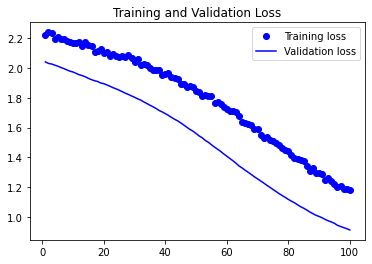

In [86]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [90]:
yhat = np.argmax(model.predict(X_train), axis=1)
y_actual = np.argmax(y_train, axis=1)
print(np.count_nonzero(yhat != y_actual)/len(yhat))

TypeError: object of type 'numpy.int64' has no len()

In [88]:
np.unique(yhat)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [103]:
from sklearn.metrics import accuracy_score
yhat = model.predict(X_test)
yhat = np.argmax(yhat, axis=1)
y_test_actual = np.argmax(y_test, axis=1)

print(accuracy_score(y_true, y_pred))

array([1, 2, 4, 6, 2, 3, 3, 7, 7, 5, 6, 2, 4, 5, 3, 1, 2, 7, 1, 5, 6, 2,
       2, 7, 1, 0, 7, 6, 1, 5, 2, 6, 2, 6, 1, 2, 6, 7, 7, 7, 2, 2, 7, 7,
       6, 0, 2, 6, 5, 0, 1, 0, 5, 3, 2, 2, 5, 6, 7, 7, 7, 7, 2, 6, 3, 6,
       5, 5, 3, 3, 0, 2, 0, 4, 7, 0, 2, 0, 0, 2, 1, 2, 7, 5, 0, 5, 2, 1,
       1, 3, 3, 4, 1, 0, 6, 7, 6, 2, 5, 3, 1, 2, 1, 1, 2, 7, 6, 7, 6, 6,
       7, 2, 7, 2, 6, 0, 2, 2, 6, 2, 2, 3, 2, 6, 0, 7, 0, 2, 5, 6, 7, 1,
       5, 6, 6, 5, 2, 2, 4, 6, 7, 5, 2, 2, 0, 2, 5, 1, 7, 2, 2, 6, 5, 5,
       5, 0, 6, 3, 4, 7, 7, 4, 6, 5, 5, 1, 1, 6, 4, 0, 3, 1, 5, 1, 5, 7,
       7, 6, 1, 1, 3, 7, 7, 1, 3, 0, 7, 5, 5, 0, 0, 2, 6, 2, 1, 1, 4, 3,
       2, 5, 2, 7, 2, 0, 6, 7, 7, 1, 2, 5, 5, 6, 0, 4, 2, 6, 3, 0, 3, 1,
       4, 6, 2, 7, 1, 1, 0, 6, 5, 6, 4, 5, 7, 5, 1, 5, 6, 0, 2, 6, 0, 0,
       6, 2, 0, 5, 2, 5, 3, 5, 1, 6, 5, 5, 2, 6, 2, 4, 2, 0, 1, 3, 2, 7,
       3, 3, 6, 5, 1, 7, 5, 1, 4, 0, 7, 0, 7, 7, 2, 0, 5, 1, 4, 4, 2, 6,
       0, 0, 4, 5, 0, 2, 2, 0, 4, 1, 3, 0, 1, 1, 6,

In [98]:
y_pred = [0, 2, 1, 3, 5]
y_true = [0, 1, 2, 3, 5]
print(accuracy_score(y_true, y_pred))


0.6
